In [1]:
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PC
from castle.common.priori_knowledge import PrioriKnowledge

import networkx as nx
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

2023-12-18 20:16:39,917 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-12-18 20:16:40,005 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('iwant', 'bandwidth')
                         ])

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlaz

In [4]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment', 'messageBandwidth', 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top', 'totalBandwidth':'bandwidth'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['bandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 
                  'interval', 'topology', 'propagationTime', 'messageOverhead', 'bandwidth']].to_numpy()

# X = consolidated.to_numpy()
print(X)

[[   8.    4226.       0.    ... 1880.401  579.     289.5  ]
 [   8.    3986.       0.    ... 1670.648  542.     271.   ]
 [   8.     472.       0.    ... 1710.708   72.      36.   ]
 ...
 [  21.    1241.       0.    ... 1332.562  112.      56.   ]
 [  21.     463.       0.    ...  845.742   42.      21.   ]
 [  21.    1703.       0.    ... 1218.581  154.      77.   ]]


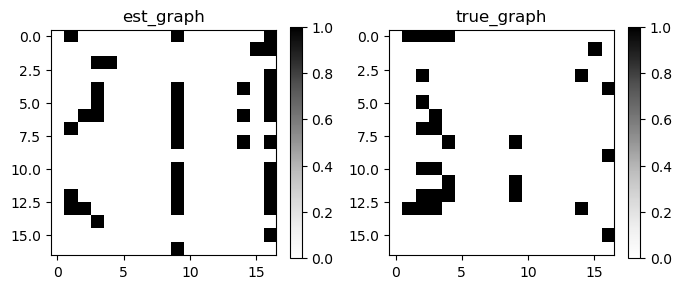

{'fdr': 0.7436, 'tpr': 0.3571, 'fpr': 0.2685, 'shd': 44, 'nnz': 39, 'precision': 0.2564, 'recall': 0.3571, 'F1': 0.2985, 'gscore': 0.0}


In [5]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
                            (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
                            (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
                            (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
                            (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
                            (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
                            (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
                            (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
                            (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(9,16)])
priori.add_required_edges([(15, 16), #messageOverhead -> messageBandwidth
                           (1, 15), #messageReceived -> messageOverhead
                           (6,2),
                           (5,3)]) #dlo -> prune
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

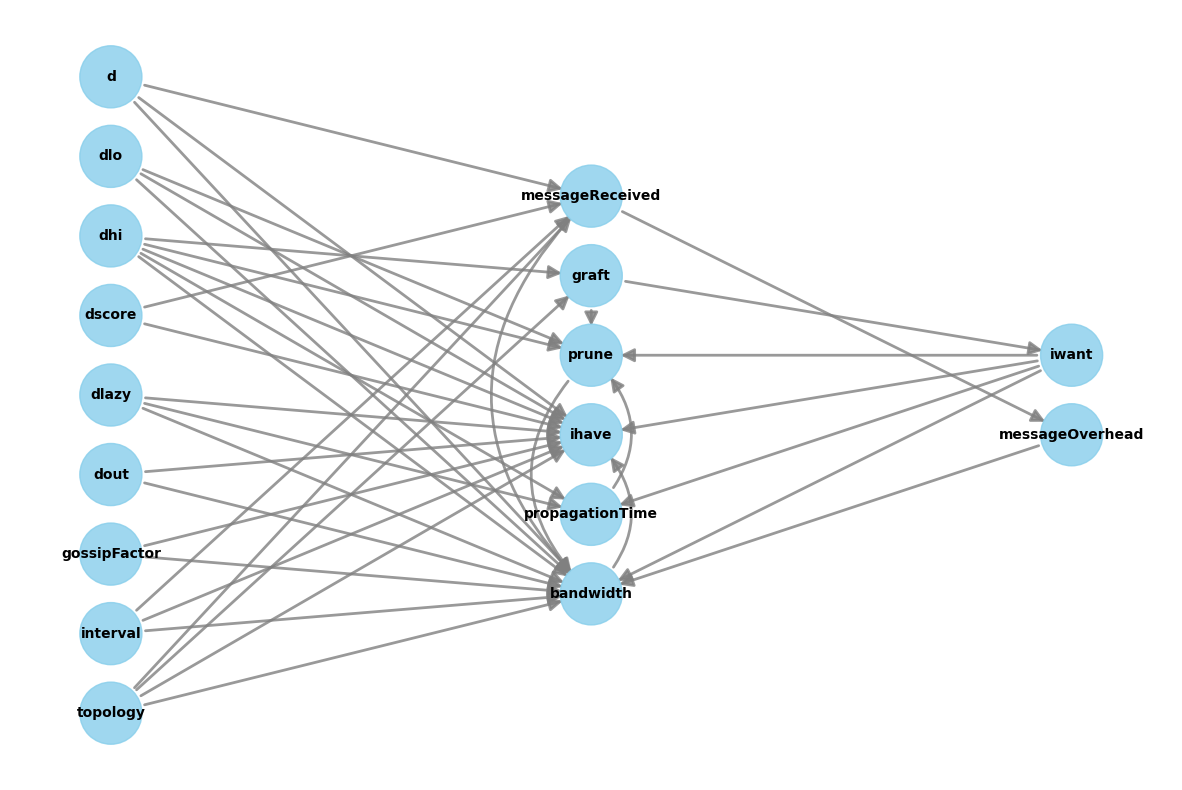

In [6]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[15, 10])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

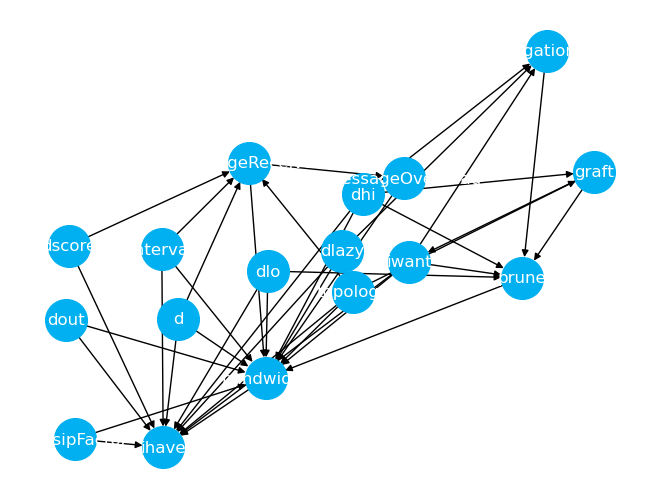

In [7]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

nx.draw(
    H, 
    with_labels=True, 
    node_size=900,
    font_color='white', 
    node_color=COLORS[0]
)

In [ ]:
pc_cat = PC(ci_test="chi2", priori_knowledge=priori)

pc_cat.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_cat.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_cat.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [ ]:
learned_causal_graph =  nx.from_numpy_array(pc_cat.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'messageBandwidth',
            17:'totalBandwidth',
            18:'gossipBandwidth'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

In [ ]:
pc_g2 = PC(ci_test="g2", priori_knowledge=priori)

pc_g2.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_g2.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_g2.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [ ]:
learned_causal_graph =  nx.from_numpy_array(pc_g2.causal_matrix, create_using=nx.DiGraph)

mapping ={0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'messageBandwidth',
            17:'totalBandwidth',
            18:'gossipBandwidth'}

H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

In [ ]:
from castle.common.independence_tests import CITest

pc_cat_alt = PC(ci_test=CITest.cressie_read, priori_knowledge=priori)
pc_cat_alt.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_cat_alt.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_cat_alt.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [ ]:
learned_causal_graph =  nx.from_numpy_array(pc_cat_alt.causal_matrix, create_using=nx.DiGraph)

{0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'messageBandwidth',
            17:'totalBandwidth',
            18:'gossipBandwidth'}

H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])